# Grad-CAM

The goal of this notebook is to calculate **Gradient-weighted Class Activation Mapping** for example images to check whether our **Champion** neural net is properly distinguishing important features. 

In [1]:
from pathlib import Path

import torch

from footvid.models import ResNet
from footvid.utils.env import check_repository_path


REPOSITORY_PATH = check_repository_path()
MODELS_PATH = REPOSITORY_PATH.joinpath("models")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


checkpoint = torch.load(
    MODELS_PATH.joinpath(
        "cnn-top2-layers-fine-tuning", 
        "checkpoint.23-09-2020.13_08_02.pth",
    ),
    map_location=DEVICE,
)
model = ResNet(output_size=1)
model.to(DEVICE)
model.load_state_dict(checkpoint["model"])
model.eval()

ResNet(
  (resnet50_conv): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets

from footvid.preprocessing import TEST_TRANSFORMS


valid_images = datasets.ImageFolder(
    root=REPOSITORY_PATH.joinpath("data", "processed", "valid"),
    transform=TEST_TRANSFORMS,
)

valid_dataloader = DataLoader(
    dataset=valid_images,  batch_size=1, shuffle=True, num_workers=2
)

Let's visualize example 10 images with their corresponding Grad-CAM.

True label: 1
Prediction: 0.95


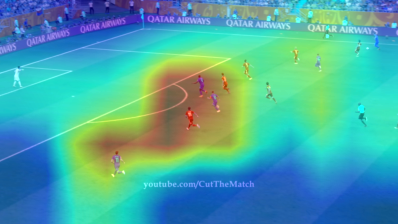

True label: 0
Prediction: 0.35


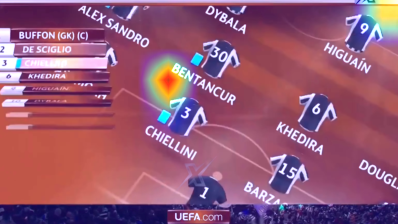

True label: 1
Prediction: 0.76


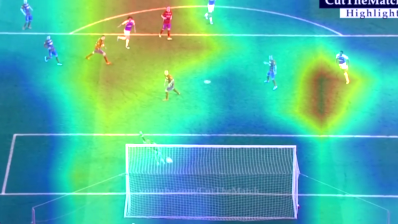

True label: 0
Prediction: 0.07


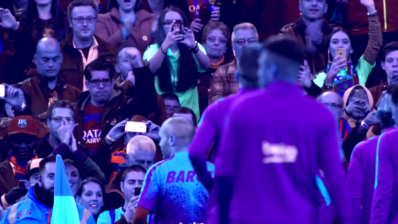

True label: 1
Prediction: 0.88


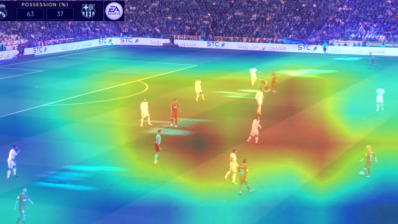

True label: 0
Prediction: 0.40


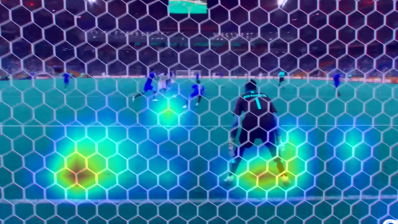

True label: 0
Prediction: 0.40


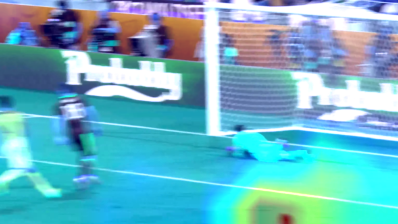

True label: 1
Prediction: 0.88


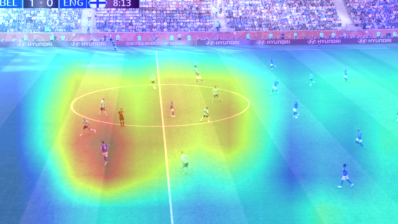

True label: 0
Prediction: 0.11


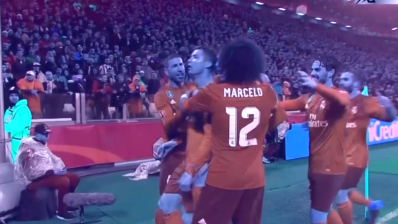

True label: 1
Prediction: 0.87


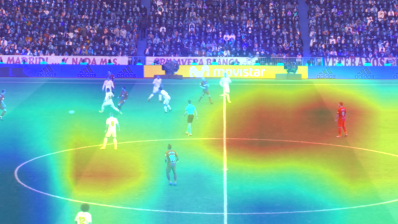

True label: 0
Prediction: 0.13


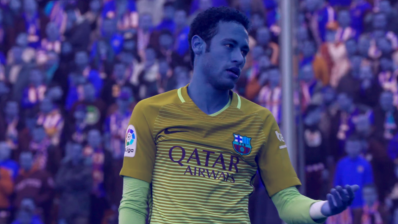

In [3]:
from copy import deepcopy

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display

from footvid.preprocessing import denormalize


for idx, (x, y) in enumerate(valid_dataloader):
    _model = deepcopy(model)
    output = _model(x)
    output.backward()
    
    gradients = _model.gradients
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    
    activations = _model.get_activations(x).detach()
    activations *= pooled_gradients.reshape(1, -1, 1, 1)

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)

    heatmap = cv2.resize(heatmap.numpy(), (x.shape[3], x.shape[2]))
    heatmap = (255 * heatmap).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * 0.5 + (255 * denormalize(x[0])).astype(np.uint8)
    gradcam_file = REPOSITORY_PATH.joinpath(
        "docs",
        "images",
        "gradcams",
        "example-{}.png".format(str(idx) if idx > 9 else "0" + str(idx)),
    )
    cv2.imwrite(
        str(gradcam_file),
        superimposed_img,
    )

    print(f"True label: {y[0]}")
    print(
        "Prediction: {0:.2f}"
        .format((1 / (1 + np.exp(-output.detach().numpy())))[0, 0])
    )
    display(Image(str(gradcam_file), width=796, height=448))

    if idx == 10:
        break

As we can see model is doing a pretty descent job in focusing on the areas that are assessed as football pitch elements. It creates features that are representing a group of players moving on the pitch, which seems to be a very good heuristic for assessing the given classification problem. Whenever there is a camera close-up or something unrelated with the football match the model easily detects that it is not a match frame, which can be seen by the lack of "warm" areas on the heatmap.